In [1]:
#basic imports
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pymongo as pm
import numpy as np
import h5py
import scipy as sp
import scipy.stats as stats
import os

from sklearn.cross_decomposition import PLSRegression

In [2]:
import regression_utils as rutils
from sklearn.model_selection import GridSearchCV

#local imports
from utils import featurewise_norm
from utils import rsquared

In [23]:
# let's bring in the brain data

#read in the mat files
with h5py.File('../data/EstimatedResponses.mat','r') as fmri_dataset:
    train_S1 = fmri_dataset['dataTrnS1'][:]
    test_S1 = fmri_dataset['dataValS1'][:]
    roi_S1 = fmri_dataset['roiS1'][:]
    
    unique_ROIs = np.unique((fmri_dataset['roiS1']))

In [24]:
print(train_S1.shape)

(1750, 25915)


In [56]:
roi_S1.shape

(1, 25915)

In [70]:
#get rid of all NaNs
S1 = train_S1.T
x=S1[~np.isnan(S1).any(axis=1)]
S1_train = x.T
print(S1_train.shape)

(1750, 22733)


In [90]:
num_vox = S1_train.shape[1]

In [72]:
print(S1.shape)
print((~np.isnan(S1).any(axis=1)).shape)

print(train_S1.shape)
print(roi_S1.shape)

(25915, 1750)
(25915,)
(1750, 25915)
(1, 25915)


In [200]:
S1r = roi_S1.T
x=S1r[~np.isnan(S1).any(axis=1)]
vox_idx = x.T
vox_idx = vox_idx[0]
print(len(vox_idx))

22733


In [281]:
num_vox_of_roi = (len(np.where(vox_idx==7)[0])
                  + len(np.where(vox_idx==6)[0])
                  + len(np.where(vox_idx==1)[0])
                  +len(np.where(vox_idx==2)[0])
                  +len(np.where(vox_idx==3)[0]))

In [110]:
#all splits for regression training
num_splits = 5
all_splits = rutils.get_splits(data=S1_train,
                               split_index=0,
                               num_splits=num_splits,
                               num_per_class_test = 250,
                               num_per_class_train = 1500)

In [16]:
# read in the alexnet features
features = {}
layer_keys = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7']
h5f = h5py.File('alexnet_train_features.h5','r')
for l in layer_keys:
    features[l] = h5f[l][:] #features for the training images
h5f.close()

In [17]:
#flatten the features
flat_features = {}
for l in layer_keys:
    shp = features[l].shape
    flat_features[l] = features[l].reshape((shp[0], np.prod(shp[1:])))
    
#and subsample the features
sub_features = {}
N = 1250
#create a random number generator with controlled seed
rng = np.random.RandomState(seed=0)
for l in layer_keys:
    #n = number of features
    n = flat_features[l].shape[1]  
    #pick a permutation of the set [0, ... n-1]
    perm = rng.permutation(n)
    #keep the first N random features
    keep_inds = perm[: N]
    sub_features[l] = flat_features[l][:, keep_inds]

In [81]:
#now, do the training
all_resdict = {}
for l in layer_keys:   #for each layer ...
    print('evaluating %s' % l)
    feats = sub_features[l]

    res = rutils.train_and_test_scikit_regressor(features=feats, 
                                                labels=S1_train,
                                                splits=all_splits,
                                                model_class=PLSRegression,
                                                model_args={'n_components': 2,
                                                            'scale': False},
                                                feature_norm=False)
    all_resdict[l] = res

evaluating conv1
evaluating conv2
evaluating conv3
evaluating conv4
evaluating conv5
evaluating fc6
evaluating fc7


In [ ]:
#for how many neurons do any layers significantly predict performance

In [89]:
#divide performance explicitly by layer
conv1 = all_resdict['conv1']['test']['mean_rsquared_array']
conv2 = all_resdict['conv2']['test']['mean_rsquared_array']
conv3 = all_resdict['conv3']['test']['mean_rsquared_array']
conv4 = all_resdict['conv4']['test']['mean_rsquared_array']
conv5 = all_resdict['conv5']['test']['mean_rsquared_array']
fc6 = all_resdict['fc6']['test']['mean_rsquared_array']
fc7 = all_resdict['fc7']['test']['mean_rsquared_array']


In [108]:
all_resdict['conv1']['test']['by_split'][split_num]['rsquared_array'][vox]

-0.006187832406611138

In [92]:
conv1[5]

-0.007981245247943658

In [97]:
best_layer_by_vox = {}
for vox in range(num_vox):
    rs_by_layer = [conv1[vox], conv2[vox], conv3[vox], conv4[vox], conv5[vox], fc6[vox], fc7[vox]]
    best_layer_by_vox[vox] = np.argmax(rs_by_layer)

In [111]:
best_layer_by_vox[100]

1

In [101]:
layer_keys[0]

'conv1'

In [284]:
print(num_vox_of_roi)

7630


In [285]:
num_test = num_vox_of_roi
bonferroni_alpha = 0.05/num_test
print(bonferroni_alpha)

6.553079947575361e-06


In [486]:
num_test = num_vox_of_roi
bonferroni_alpha = 0.05/num_test

stat_vox = []
stat_rs = {}
r_mean = []
stat_rs_mean = {}
for vox in range(num_vox):
    rs_by_split = []
    r_mean.append(all_resdict[win_key]['test']['mean_rsquared_array'][vox])
    for split in range(num_splits):
        layer_win = best_layer_by_vox[vox]
        win_key = layer_keys[layer_win]
        rs_by_split.append(all_resdict[win_key]['test']['by_split'][split]['rsquared_array'][vox])
    t, p = stats.ttest_1samp(rs_by_split, 0.0)
    p = p/2 #one-sided
    if t > 0: #only positive fits
        if p < .05:
            stat_vox.append(vox) #indices of stat sig voxels
            stat_rs[str(vox)] = rs_by_split
            stat_rs_mean[str(vox)] = r_mean

In [418]:
len(stat_vox)

2304

In [489]:
print(stat_rs_mean)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [419]:
rs_by_split

[-0.039170217594398204,
 -0.00016211729422277443,
 -0.011894552946219106,
 0.0017560821230193646,
 0.005741742490046886]

In [420]:
stat_rs

{'1': [-0.00039610570183579163,
  0.004829401749381401,
  0.00530716795350894,
  0.0039149621405807356,
  0.0007328455479352902],
 '9': [0.06962433521333189,
  0.05175774006614864,
  0.023742121893278734,
  0.04450823634668666,
  0.051653302280949],
 '10': [0.030165604765154508,
  0.03461588304758478,
  -0.0018109060295961044,
  0.003612301514746452,
  0.025334982060959854],
 '11': [0.00973956479671434,
  0.010112781185341646,
  -5.088297475475123e-05,
  0.0061829160448405585,
  0.008127016811269372],
 '23': [0.023072249713116277,
  0.03638745309271074,
  0.013227022773662389,
  0.042170662513310364,
  0.04505972299653482],
 '38': [0.03650696246397733,
  0.046333352127058025,
  0.02766909518293581,
  0.006491541612820062,
  0.03742093749320874],
 '66': [0.003382024042132281,
  0.008038922804735282,
  0.0036297777427717337,
  0.015066126288939441,
  0.01627632205012386],
 '75': [0.022013631689802304,
  0.0014572057304249597,
  0.05526344435623298,
  0.030547895603412534,
  0.01505904350

(array([781., 380., 458.,   0., 226.,  50.,   0.,  43., 214., 152.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

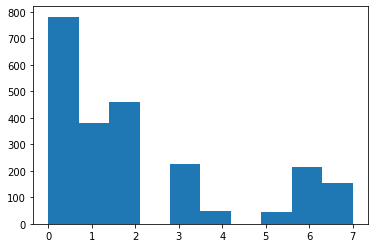

In [421]:
plt.hist(vox_idx[stat_vox])

In [422]:
vox_idx

array([0., 0., 0., ..., 0., 0., 0.])

In [423]:
sum(vox_idx[stat_vox]==6) #num of stat sig V4 vox

214

In [424]:
np.where(vox_idx==6)

(array([ 1565,  1618,  1635, ..., 22679, 22680, 22711]),)

In [425]:
V4_idx = np.where(vox_idx==6)

In [426]:
len(stat_vox)

2304

In [427]:
len(V4_idx[0])

1535

In [428]:
V4_idx_list = V4_idx[0].tolist()

In [429]:
v4_sig_idx = set(V4_idx_list).intersection(stat_vox)

In [430]:
V4_layer_win = []
i = 0
for V4_vox in v4_sig_idx:
    V4_layer_win.append(best_layer_by_vox[V4_vox])
    stat_rs[str(V4_vox)]
    i += 1

(array([ 4., 32., 85., 18., 42., 26.,  7.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

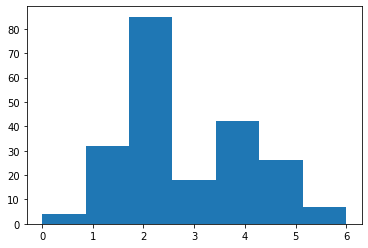

In [431]:
plt.hist(V4_layer_win,bins = 7) #yay conv3 won!

In [432]:
LO_idx = np.where(vox_idx==7)
LO_idx_list = LO_idx[0].tolist()
LO_sig_idx = set(LO_idx_list).intersection(stat_vox)

In [433]:
LO_layer_win = []
i = 0
for LO_vox in LO_sig_idx:
    LO_layer_win.append(best_layer_by_vox[LO_vox])
    stat_rs[str(LO_vox)]
    i += 1

(array([10., 48.,  4.,  0., 29., 16., 45.]),
 array([1.        , 1.71428571, 2.42857143, 3.14285714, 3.85714286,
        4.57142857, 5.28571429, 6.        ]),
 <a list of 7 Patch objects>)

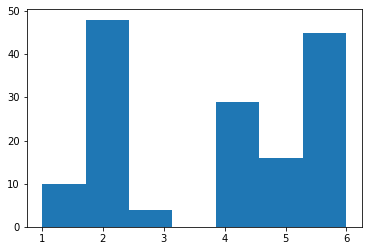

In [434]:
plt.hist(LO_layer_win,bins = 7) #later layers maybe?

In [435]:
#### okay now V1
V1_idx = np.where(vox_idx==1)
V1_idx_list = V1_idx[0].tolist()
V1_sig_idx = set(V1_idx_list).intersection(stat_vox)

In [436]:
V1_layer_win = []
i = 0
for V1_vox in V1_sig_idx:
    V1_layer_win.append(best_layer_by_vox[V1_vox])
    stat_rs[str(V1_vox)]
    i += 1

(array([  8., 170., 152.,  28.,  19.,   1.,   2.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

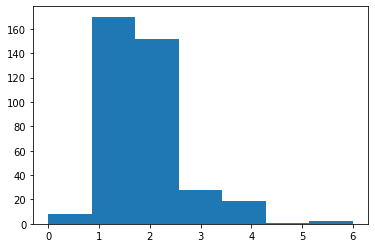

In [437]:
plt.hist(V1_layer_win,bins = 7) #yay good!

(array([  9., 185., 171.,  48.,  29.,   8.,   8.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

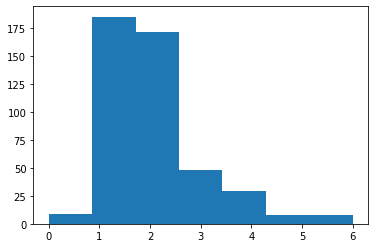

In [438]:
#### okay now V2
V2_idx = np.where(vox_idx==2)
V2_idx_list = V2_idx[0].tolist()
V2_sig_idx = set(V2_idx_list).intersection(stat_vox)

V2_layer_win = []
i = 0
for V2_vox in V2_sig_idx:
    V2_layer_win.append(best_layer_by_vox[V2_vox])
    stat_rs[str(V2_vox)]
    i += 1
    
plt.hist(V2_layer_win,bins = 7)    

(array([10., 51., 73., 46., 23., 14.,  9.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

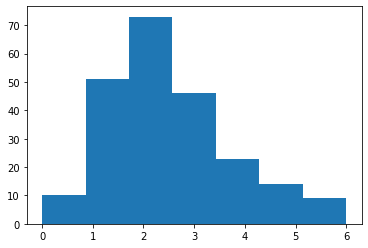

In [439]:
#### okay now V3
V3_idx = np.where(vox_idx==3)
V3_idx_list = V3_idx[0].tolist()
V3_sig_idx = set(V3_idx_list).intersection(stat_vox)

V3_layer_win = []
i = 0
for V3_vox in V3_sig_idx:
    V3_layer_win.append(best_layer_by_vox[V3_vox])
    stat_rs[str(V3_vox)]
    i += 1
    
plt.hist(V3_layer_win,bins = 7)    

In [440]:
#get proportions
#V1
V1_props = []
V1_vox = len(V1_layer_win)
for l in range(len(layer_keys)):
    V1_props.append(V1_layer_win.count(l)/V1_vox)
    
#V2
V2_props = []
V2_vox = len(V2_layer_win)
for l in range(len(layer_keys)):
    V2_props.append(V2_layer_win.count(l)/V2_vox)

#V3
V3_props = []
V3_vox = len(V3_layer_win)
for l in range(len(layer_keys)):
    V3_props.append(V3_layer_win.count(l)/V3_vox)

#V4
V4_props = []
V4_vox = len(V4_layer_win)
for l in range(len(layer_keys)):
    V4_props.append(V4_layer_win.count(l)/V4_vox)

#LO
LO_props = []
LO_vox = len(LO_layer_win)
for l in range(len(layer_keys)):
    LO_props.append(LO_layer_win.count(l)/LO_vox)

In [441]:
LO_props

[0.0,
 0.06578947368421052,
 0.3157894736842105,
 0.02631578947368421,
 0.19078947368421054,
 0.10526315789473684,
 0.29605263157894735]

In [442]:
len(layer_keys)

7

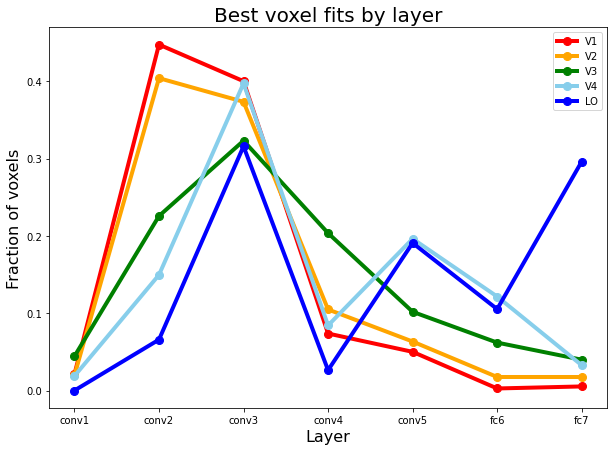

In [443]:
plt.figure(figsize=(10,7))
plt.plot(layer_keys, V1_props, marker='o', markerfacecolor='r', markersize=8, color='r', linewidth=4, label = 'V1')
plt.plot(layer_keys, V2_props, marker='o', markerfacecolor='orange', markersize=8, color='orange', linewidth=4, label = 'V2')
plt.plot(layer_keys, V3_props, marker='o', markerfacecolor='green', markersize=8, color='green', linewidth=4, label = 'V3')
plt.plot(layer_keys, V4_props, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, label = 'V4')
plt.plot(layer_keys, LO_props, marker='o', markerfacecolor='blue', markersize=8, color='blue', linewidth=4, label = 'LO')

plt.xlabel('Layer', fontsize = 16)
plt.ylabel('Fraction of voxels', fontsize = 16)
plt.title('Best voxel fits by layer', fontsize = 20)

plt.legend(loc='upper right')

plt.savefig('../figures/S1_layerwise_alexnet_fits_05.png')

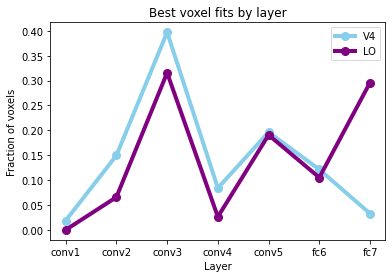

In [444]:
plt.plot(layer_keys, V4_props, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, label = 'V4')
plt.plot(layer_keys, LO_props, marker='o', markerfacecolor='purple', markersize=8, color='purple', linewidth=4, label = 'LO')

plt.xlabel('Layer')
plt.ylabel('Fraction of voxels')
plt.title('Best voxel fits by layer')

plt.legend()

#plt.savefig('../figures/S1_layerwise_alexnet_fits.png')

In [274]:
len(np.where(vox_idx==7)[0])+len(np.where(vox_idx==6)[0])+ len(np.where(vox_idx==1)[0])+len(np.where(vox_idx==2)[0])+len(np.where(vox_idx==3)[0])

7630

In [275]:
len(np.where(vox_idx==0)[0])

14305

In [470]:
sum((all_resdict['conv3']['test']['mean_rsquared_array'])>.1)

101

In [472]:
np.max(all_resdict['conv3']['test']['mean_rsquared_array'])

0.22302872079985728

In [474]:
all_ = all_resdict['conv3']['test']['mean_rsquared_array']

In [475]:
top = all_[all_>.1]

In [476]:
top

array([0.11363616, 0.10443913, 0.10637388, 0.15068784, 0.12615136,
       0.10695562, 0.15058823, 0.11078297, 0.12042856, 0.12499575,
       0.11930513, 0.11325004, 0.13658652, 0.11909916, 0.13394086,
       0.12494516, 0.15875354, 0.12409587, 0.14913846, 0.18422306,
       0.12468247, 0.10770102, 0.13802441, 0.10381722, 0.10124226,
       0.10199634, 0.12662148, 0.18029666, 0.15600424, 0.12059769,
       0.10704522, 0.11679224, 0.19125098, 0.19193096, 0.15554675,
       0.12117541, 0.1345276 , 0.10062651, 0.11375401, 0.16335426,
       0.1130883 , 0.13163288, 0.16817095, 0.14274289, 0.1053033 ,
       0.10005461, 0.1448797 , 0.20165085, 0.19488174, 0.19772245,
       0.18599401, 0.13749119, 0.14340573, 0.13377685, 0.11659248,
       0.22302872, 0.17066696, 0.1715143 , 0.13215894, 0.11036361,
       0.11883497, 0.13758545, 0.17572128, 0.18040848, 0.10652391,
       0.10202716, 0.1130995 , 0.14872909, 0.11404833, 0.14915186,
       0.12056628, 0.12730172, 0.18872038, 0.10379352, 0.16715

In [477]:
len(top)

101

In [485]:
np.max(all_resdict['conv2']['test']['mean_rsquared_array'])

0.23405790683974975